# Imports

In [7]:
import os
import librosa
import soundfile as sf
from pydub import AudioSegment
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import warnings
warnings.filterwarnings("ignore")


# Introduction

## 1. Project Objective
#### The goal of this project is to develop a model capable of automatically classifying speech defects from short audio samples.  

The initial prototype focuses on binary classification of:
- **normal speech**
- **articulation disorders** (e.g., mispronunciations, phonetic deviations)

A third class, **stuttering**, will be integrated in the next iteration after additional dataset acquisition (CLASS / SEP-28k).  

## 2. Datasets Used

For this project we rely on two primary sources:

### 1. Articulation Disorders Dataset  
Contains recordings of subjects with various articulation impairments.  
Directory example:

`dataset_raw/articulation/M05/Session1/wav_arrayMic/0001.wav`

### 2. Normal Speech Dataset (LibriSpeech Subset) 
Contains clean speech samples from speakers without speech impairments.  
Directory example:

`dataset_raw/normal/dev-clean/batch1/1993/147964/1993-147964-0000.wav`


# Dataset Exploration
## Printing directory structure

In [10]:
INPUT_DIR = "dataset_raw"

for root, dirs, files in os.walk(INPUT_DIR):
    print(root)
    print(" Subdirectories:", dirs)
    break  # printing only top-level

dataset_raw
 Subdirectories: ['articulation', 'normal']


## Inspecting number of files per class

In [11]:
def count_audio_files(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += len([f for f in files if f.lower().endswith(".wav")])
    return count

normal_count = count_audio_files(os.path.join(INPUT_DIR, "normal"))
articulation_count = count_audio_files(os.path.join(INPUT_DIR, "articulation"))

print("Normal speech files:", normal_count)
print("Articulation disorder files:", articulation_count)

Normal speech files: 625
Articulation disorder files: 6179


## Load and display waveform

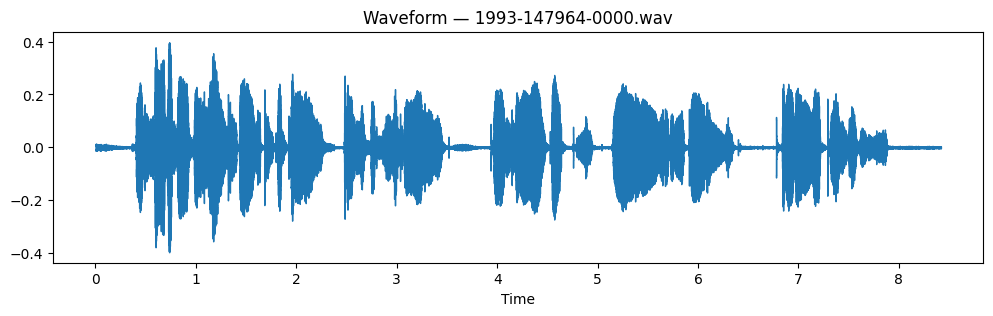

Sampling rate: 16000
Duration (sec): 8.42


In [12]:
sample_path = "dataset_raw/normal/dev-clean/batch1/1993/147964/1993-147964-0000.wav"

audio, sr = librosa.load(sample_path, sr=None, mono=True)

plt.figure(figsize=(12, 3))
librosa.display.waveshow(audio, sr=sr)
plt.title(f"Waveform — {os.path.basename(sample_path)}")
plt.show()

print("Sampling rate:", sr)
print("Duration (sec):", len(audio) / sr)

## Playing audio sample

In [13]:
Audio(sample_path)

# Data Preprocessing
## Converting to mono and resampling (16 kHz)

In [14]:
def load_audio(path, target_sr=16000):
    try:
        audio, sr = librosa.load(path, sr=target_sr, mono=True)
        return audio, target_sr
    except Exception as e:
        return None, None

## RMS normalization

In [15]:
def normalize_audio(audio):
    rms = np.sqrt(np.mean(audio**2))
    target_rms = 0.03  # -30 dB
    if rms > 0:
        audio = audio * (target_rms / rms)
    return audio

## Cutting into 3-5 second Chunks

In [16]:
def split_audio(audio, sr, min_sec=3, max_sec=5):
    chunk_len = np.random.randint(min_sec, max_sec + 1) * sr
    chunks = []

    for start in range(0, len(audio), chunk_len):
        end = start + chunk_len
        chunk = audio[start:end]
        if len(chunk) < min_sec * sr:
            continue
        chunks.append(chunk)

    return chunks

## Single file processing function

In [17]:
def process_file(input_path, output_dir, label, errors_log):
    audio, sr = load_audio(input_path)

    if audio is None:
        errors_log.append(f"Failed to load: {input_path}")
        return

    audio = normalize_audio(audio)
    chunks = split_audio(audio, sr)

    if len(chunks) == 0:
        errors_log.append(f"No suitable chunks: {input_path}")
        return

    # creating directory
    class_dir = os.path.join(output_dir, label)
    os.makedirs(class_dir, exist_ok=True)

    # saving chunks
    base_name = os.path.splitext(os.path.basename(input_path))[0]

    for idx, chunk in enumerate(chunks):
        out_path = os.path.join(class_dir, f"{base_name}_{idx}.wav")
        sf.write(out_path, chunk, sr)

## Main function for prerocessing

In [18]:
def preprocess_dataset(input_root, output_root):
    errors = []

    # groups for preprocess
    classes = ["normal", "articulation"]

    for label in classes:
        input_path = os.path.join(input_root, label)

        # recursively traversing all subfolders
        for root, dirs, files in os.walk(input_path):
            for fname in tqdm(files, desc=f"Processing {label}"):
                if not fname.lower().endswith(".wav"):
                    continue

                full_path = os.path.join(root, fname)
                process_file(full_path, output_root, label, errors)

    return errors

# running the function
OUTPUT_DIR = "dataset"

errors = preprocess_dataset(INPUT_DIR, OUTPUT_DIR)

Processing normal: 0it [00:00, ?it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 100%|██████████| 53/53 [00:00<00:00, 329.39it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 100%|██████████| 17/17 [00:00<00:00, 174.01it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 100%|██████████| 65/65 [00:00<00:00, 345.81it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 100%|██████████| 32/32 [00:00<00:00, 299.80it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 100%|██████████| 17/17 [00:00<00:00, 299.17it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 100%|██████████| 44/44 [00:00<00:00, 261.41it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 100%|██████████| 6/6 [00:00<00:00, 221.05it/s]
Processing normal: 0it [00:00, ?it/s]
Processing normal: 100%|██████████| 26/26 [00:00<00:00, 388.01it/s]
Processing normal: 0it [00:00, ?it/s]
Pr

## Saving error logs

In [19]:
with open("prep_errors.log", "w") as f:
    for e in errors:
        f.write(e + "\n")

print("Errors logged to prep_errors.log")

Errors logged to prep_errors.log


# Dataset CSV

# Data Loader

# Model Training

# Evaluation

# Conclusion